# Opening the black box of Deep Neural Networks with Information

In [1]:
import numpy as np
import torch.optim
import torch
import torch.nn as nn
from torch.autograd import Variable

In [2]:
from experimental_setup import ZivInformationPlane, BufferedSequential, mutual_information_for_network_family

In [3]:
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

def experiment(base_network, X, y, 
               epochs=100, lr=.2, batch_size=101, 
               network_copies=1, 
               plot='dynamic', 
               activation_bins=np.linspace(-1,1,50)):
    loss = torch.nn.MSELoss()
    network_copies = [copy.deepcopy(base_network) for _ in range(network_copies)]
    solvers = [torch.optim.SGD(params=network.parameters(), lr=lr) for network in network_copies]
    infoplane = ZivInformationPlane(X, y, bins=activation_bins)
    
    if plot == 'dynamic' or plot == 'once':
        fig = plt.figure(figsize=(12,5))
        graph = fig.add_subplot(111)
        
    if plot == 'once':
        mi_history = [[] for _ in range(base_network.n_buffers)]
    
    for epoch in range(epochs):
        for network, solver in zip(network_copies, solvers):
            slice_ = np.random.permutation(range(len(X)))[:batch_size]
            X_batch = Variable(torch.from_numpy(X[slice_])).float()
            y_batch = Variable(torch.from_numpy(y[slice_, np.newaxis])).float()

            solver.zero_grad()
            pred_batch = network(X_batch)

            loss(pred_batch, y_batch).backward()
            solver.step()
        
        mi = mutual_information_for_network_family(infoplane, network_copies)
        
        if plot == 'dynamic':
            graph.scatter(*zip(*mi), s=10, c=np.linspace(0, 1, base_network.n_buffers), alpha=epoch/epochs)
            
            for history, new_point in zip(mi_history, mi):
                history.append(new_point)

            display.clear_output(wait=True)
            display.display(fig)
        elif plot == 'once':
            for history, new_point in zip(mi_history, mi):
                history.append(new_point)
        
    if plot == 'once':
        for history in mi_history:
            graph.plot(*zip(*history))
            
    return network_copies

## Data

In [4]:
X = np.random.randint(5, size=(1000, 12)) - 1
y = (np.mean(X, axis=1) + np.random.normal(scale=0.1, size=1000) > 0.7).astype(np.int)
Y = y.reshape(-1, 1)

## Warm up

In [5]:
layers = [
    nn.Linear(12, 5),
    nn.Tanh(),
    nn.Linear(5, 1),
    nn.Tanh()
    ]
buffer_mask = [False, True, False, True]
architecture = BufferedSequential(layers, buffer_mask)

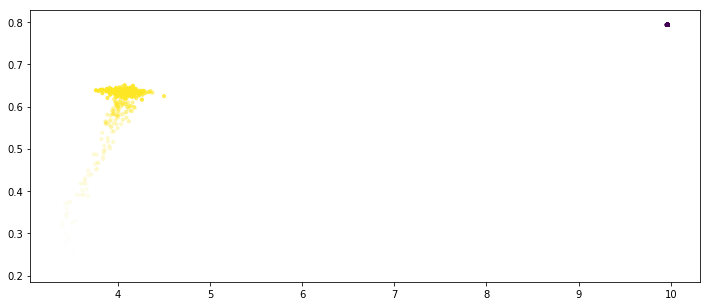

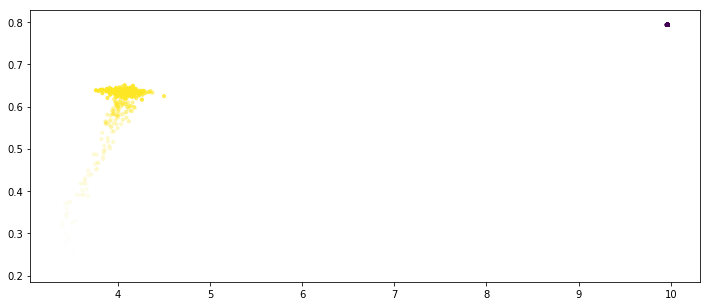

In [885]:
result_1layer = experiment(architecture, X, Y, epochs=300, network_copies=1, plot='dynamic')[0]

## Replication

In [863]:
layers = [
    nn.Linear(12, 10),
    nn.Tanh(),
    nn.Linear(10, 7),
    nn.Tanh(),
    nn.Linear(7, 5),
    nn.Tanh(),
    nn.Linear(5, 4),
    nn.Tanh(),
    nn.Linear(4, 3),
    nn.Tanh(),
    nn.Linear(3, 1),
    nn.Tanh()
    ]
buffer_mask = [False, True, False, True, False, True, False, True, False, True, False, True]
architecture = BufferedSequential(layers, buffer_mask)

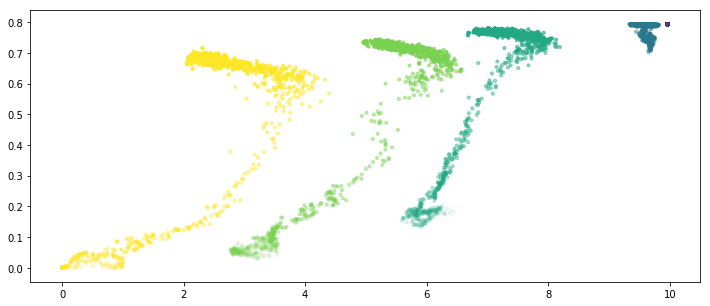

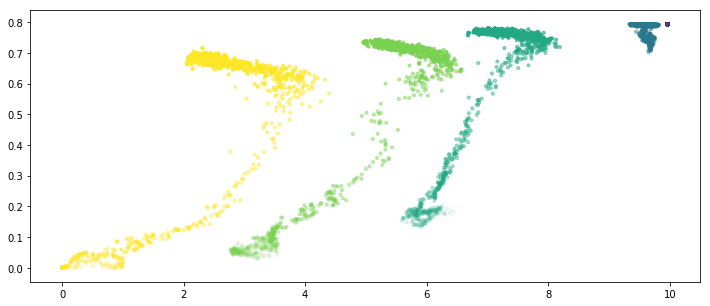

In [872]:
result_nets = experiment(architecture, X, Y, epochs=1000, network_copies=1, plot='dynamic')

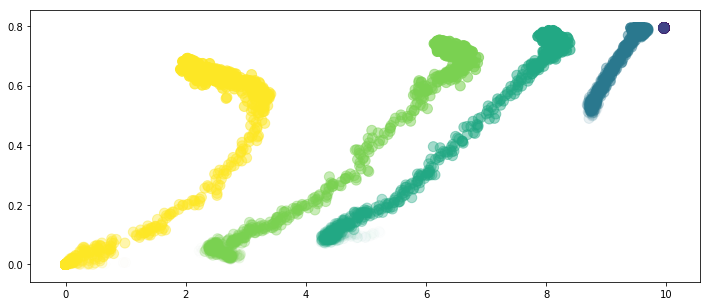

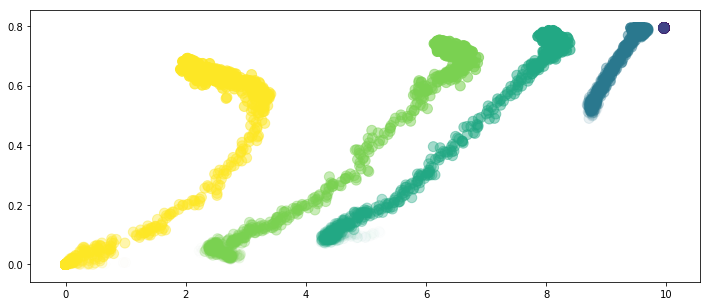

In [865]:
result_nets = experiment(architecture, X, Y, epochs=1000, network_copies=5, plot='dynamic')

## Different neural network architectures

## Takeaways